# Notebook for Time Series with RNN

Based on Duke ECE.685D. 

Used for training E-Sentience personnel

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## __Review of RNN (almost Elman model) in PyTorch:__ ($\sigma$ means Sigmoid function)
* ### In (almost) Elman model (SRNN):  $\ \ \ \ y_t= h_t = \sigma(W_{ih}x_t + b_{ih} + W_{hh}h_{t-1} + b_{hh})$
* ### In the original Elman model: \begin{array}{l} h_t = \sigma(W_{ih}x_t + b_{ih} + W_{hh}h_{t-1} + b_{hh}) \\
                                                y_t = \sigma(W_{yh}h_t + b_{yh})\\ \end{array}
* ### Sometime, there is only __one__ bias. 
## __Tensor shapes:__
* ### __$output, h_n$ = nn.RNN__($dim_x$, &nbsp; $dim_h$, &nbsp; No. of layers, &nbsp; nonlinearity(Tanh), &nbsp; bias (True), &nbsp; batch_ first (False), &nbsp; dropout (0), &nbsp; bidir (False))
* ### __Input tesor:__ (length (time steps),&nbsp; batch_size,&nbsp; $dim_x$)
* ### __Initial hidden state ($h_0$):__ (No. of layers$\times$No. of dir, &nbsp; batch_size, &nbsp; $dim_h$)
* ### __Output or hidden states (last layer):__ (length (time steps), &nbsp; batch_size, &nbsp; $dim_h\times $ No. of dir)
* ### __Last hidden state ($h_{length-1}$):__ (No. of layers$\times$No. of dir, &nbsp; batch_size, &nbsp; $dim_h$) --- __It is called $h_n$__

* ### Keras and Tensorflow have batch size in their first dimension.

## __Review of LSTM in PyTorch:__ ($\sigma$ means Sigmoid function)
* ### In LSTM model: \begin{array}{l} i_t = u_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi}) \ -------\ \rm{Update \ gate}\\
                                      f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf}) \ -------\ \rm{Forget \ gate}\\
                                      o_t = \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho}) \ -------\ \rm{Output \ gate}\\
                                      g_t = tanh(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})  \ -------\ \rm{Cell \ gate}\\
                                      c_t = f_t*c_{t-1} + u_t*g_t  \ -------\ \rm{Cell \ state}\\
                                      h_t = o_t*tanh(c_t)\ -------\ \rm{Hidden \ state} \end{array}  
## __Tensor shapes:__
* ### __$output, (h_n, c_n)$ = nn.LSTM__($dim_x$, &nbsp; $dim_h$, &nbsp; No. of layers,  &nbsp; bias (True), &nbsp; batch_ first (False), &nbsp; dropout (0), &nbsp; bidir (False))
* ### __Input tesor:__ (length (time steps),&nbsp; batch_size,&nbsp; $dim_x$)
* ### __Initial hidden state ($h_0$):__ (No. of layers$\times$No. of dir, &nbsp; batch_size, &nbsp; $dim_h$)
* ### __Initial cell state ($c_0$):__ (No. of layers$\times$No. of dir, &nbsp; batch_size, &nbsp; $dim_h$)
* ### __Output or hidden states (last layer):__ (length (time steps), &nbsp; batch_size, &nbsp; $dim_h\times $ No. of dir)
* ### __Last hidden state ($h_{length-1}$):__ (No. of layers$\times$No. of dir, &nbsp; batch_size, &nbsp; $dim_h$) --- __It is called $h_n$__
* ### __Last cell state ($c_{length-1}$):__ (No. of layers$\times$No. of dir, &nbsp; batch_size, &nbsp; $dim_h$) --- __It is called $c_n$__

* ### In a multilayer LSTM, the input $x^{(l)}_t$ of the $l^{th}$ layer ($l \geq 2$ ) is given by the hidden state $h^{(l-1)}_t$ of the previous layer multiplied by a dropout factor, $\delta^{(l-1)}_t$, where each $\delta^{(l-1)}_t$  is a Bernoulli random variable with probability being 0 given by the "dropout" input argumnet.

* ### Keras and Tensorflow have batch size in their first dimension.

# __Defining functions for creating the time series__

In [9]:
def trend(time, slope):
    return slope*time
def seasonality_pattern(season_time):
    return np.where(season_time <0.4, np.cos(2*np.pi*season_time), 1 / np.exp(3 * season_time))
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonality_pattern(season_time)
def noise(time, noise_level=1):
    return np.random.randn(len(time)) * noise_level
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# __Creating time series and setting parameters__

In [10]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + \
                    noise(time, noise_level)
split_time = 1000
window_size = 20
batch_size = 32
input_dim = 1
hidden_dim = 40
out_dim = 1
num_layers = 2
num_dir = 1
num_epochs = 100
learning_rate = 0.0001
rnn_module = "srnn"   #srnn  lstm

time_train = time[:split_time]
x_train = series[:split_time]
time_test = time[split_time:]
x_test = series[split_time:]

###### for prediction ############
series_t = torch.tensor(series)
series_t = torch.unsqueeze(series_t, dim=1)
series_t = torch.unsqueeze(series_t, dim=1)

# __Plotting the created time series__

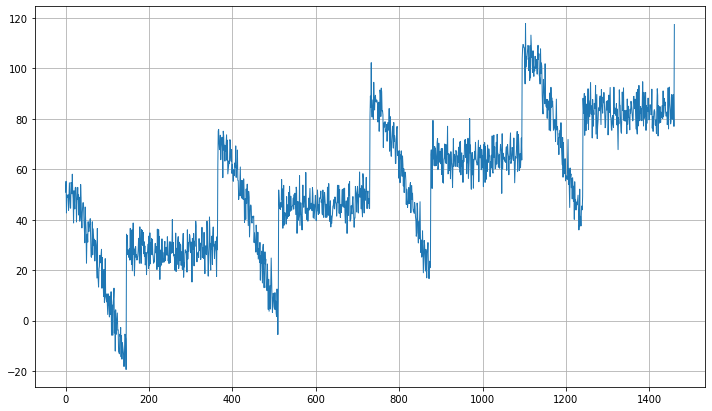

In [11]:
plt.figure(figsize=(12, 7))
plt.plot(time, series, "-", linewidth=1)
plt.grid()

# __Preparing time series by windowing it and creating the data loader__

In [10]:
def Windowed_Dataset(series, window_size, stride, batch_size):
    f_s = window_size + 1
    l = len(series)
    ds = torch.from_numpy(series)
    ds = torch.unsqueeze(ds, dim=1)
    ds = [ds[i:i+f_s] for i in range(0, l, stride) if i <= l-f_s]
    ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)
    return ds_loader
train_loader = Windowed_Dataset(x_train, window_size=window_size, stride=1, batch_size=batch_size)
test_loader = Windowed_Dataset(x_test, window_size=window_size, stride=1, batch_size=batch_size)

# __Creating RNN models__

In [11]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.out_dim = out_dim 
        self.bs = batch_size
        self.nd = num_dir
        if self.nd == 2:
            bidir = True
        else:
            bidir = False
        if rnn_module == "srnn":
            self.rnnmodule = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidir)
        elif rnn_module == "lstm":
            self.rnnmodule = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidir)
        self.linear = nn.Linear(self.hidden_dim*self.nd, self.out_dim)
    
    def forward(self, x):
#         h0 = torch.zeros(self.num_layers, self.bs, self.hidden_dim).to(device)
        out, _ = self.rnnmodule(x)
        out = self.linear(out[-1])
        out = out*100
        return out

## __Model, Loss function and Optimizer__

In [12]:
model = RNN(input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module)
model = model.to(device)
criterion = nn.SmoothL1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## __Training and testing the RNN model for prediction__

In [13]:
best_loss = 1e+100
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    running_test_loss = 0
    for batch_index, item in enumerate(train_loader):
        inputs = item[0:batch_size,0:-1]
        inputs = torch.transpose(inputs, 0, 1)
        inputs = inputs.float()
        inputs = inputs.to(device)
        target = item[0:batch_size,-1:].squeeze(dim=1)
        target = target.float()
        target = target.to(device)
        
        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()       
    with torch.no_grad():
        for batch_index, item in enumerate(test_loader):
            inputs_test = item[0:batch_size,0:-1]
            inputs_test = torch.transpose(inputs_test, 0, 1)
            inputs_test = inputs_test.float()
            inputs_test = inputs_test.to(device)
            target_test = item[0:batch_size,-1:].squeeze(dim=1)
            target_test = target_test.float()
            target_test = target_test.to(device)

            out_test = model(inputs_test)
            loss_test = criterion(out_test, target_test)
            running_test_loss += loss_test.item()
        if epoch%10 == 0:
            print('Epoch {} : Training loss is {:.4f} \
                '.format(epoch, running_train_loss/(batch_index+1)))
            print('Epoch {} : Test loss is {:.4f} \
                '.format(epoch, running_test_loss/(batch_index+1)))
        if best_loss > running_test_loss*batch_size/len(x_test):
            torch.save(model, 'ckpt_time_series.pth')
            best_loss = running_test_loss*batch_size/len(x_test)

Epoch 0 : Training loss is 27.9229                 
Epoch 0 : Test loss is 30.6301                 


C:\Users\mreso\Anaconda3\envs\DL\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 10 : Training loss is 10.7831                 
Epoch 10 : Test loss is 8.3391                 
Epoch 20 : Training loss is 10.3605                 
Epoch 20 : Test loss is 5.7446                 
Epoch 30 : Training loss is 9.8411                 
Epoch 30 : Test loss is 5.4429                 
Epoch 40 : Training loss is 10.0583                 
Epoch 40 : Test loss is 5.0022                 
Epoch 50 : Training loss is 9.7616                 
Epoch 50 : Test loss is 5.4108                 
Epoch 60 : Training loss is 9.7576                 
Epoch 60 : Test loss is 5.0688                 
Epoch 70 : Training loss is 9.6639                 
Epoch 70 : Test loss is 4.6989                 
Epoch 80 : Training loss is 9.6430                 
Epoch 80 : Test loss is 5.2530                 
Epoch 90 : Training loss is 9.7576                 
Epoch 90 : Test loss is 4.8963                 


## __Predicting the test time steps__

In [14]:
model = torch.load('ckpt_time_series.pth')
model.eval()
model = model.to(device)
forcast = []
for time_step in range(len(series) - window_size):
    Input_time = series_t[time_step:time_step+window_size,:,:]
    Input_time = Input_time.float()
    Input_time = Input_time.to(device)
    forcast.append(model(Input_time))
result = forcast[split_time-window_size:]

## __Plotting the resuts__

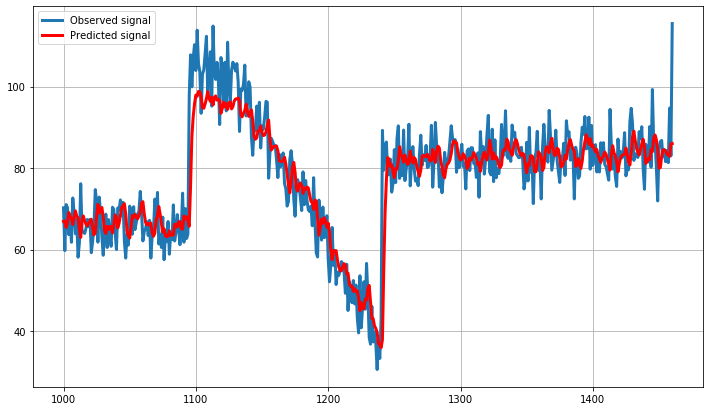

In [15]:
plt.figure(figsize=(12, 7))
plt.plot(time_test, x_test, lw = 3)
plt.plot(time_test, result, lw = 3, c = 'r')
plt.grid()
plt.legend(['Observed signal', 'Predicted signal'])